# Explore here

In [8]:
# Your code here
# =========================
# Paso 1: Carga de datos
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
df = pd.read_csv(url)

print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Distribución de Outcome (0 = no diabetes, 1 = diabetes):
 Outcome
0    500
1    268
Name: count, dtype: int64
Proporción clase positiva: 0.3489583333333333


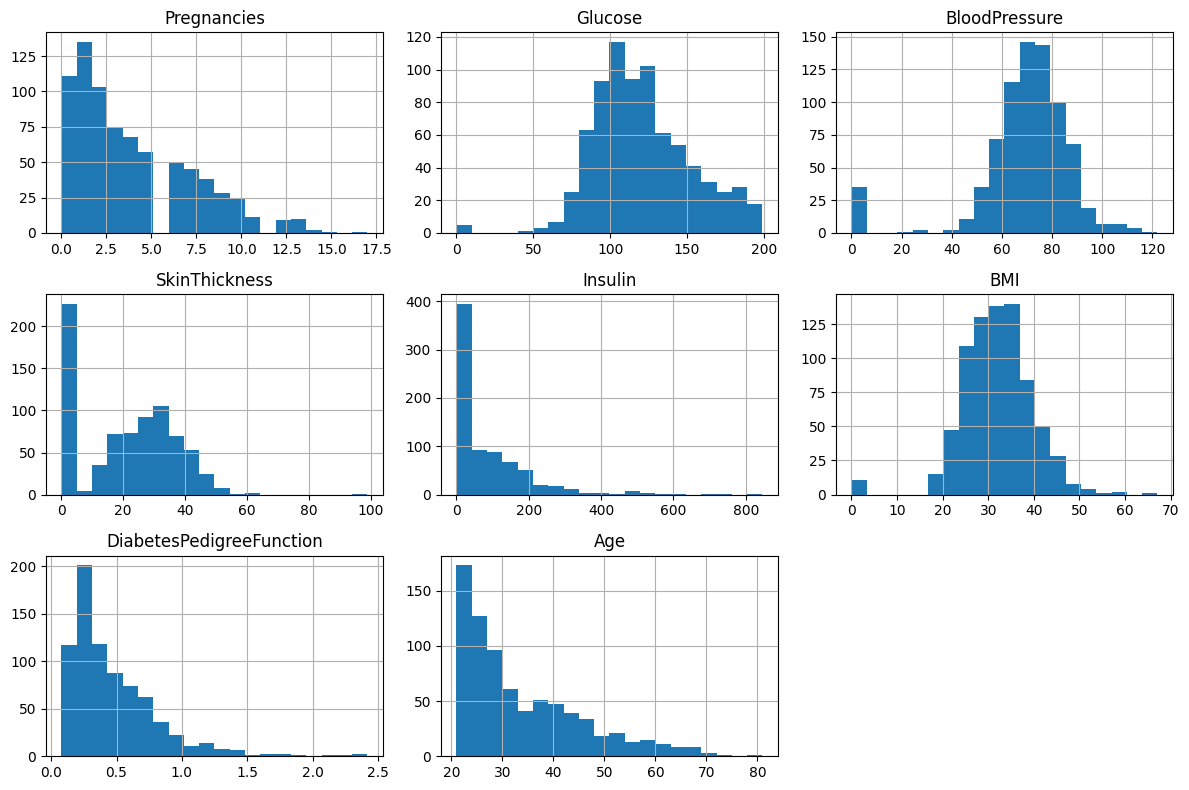

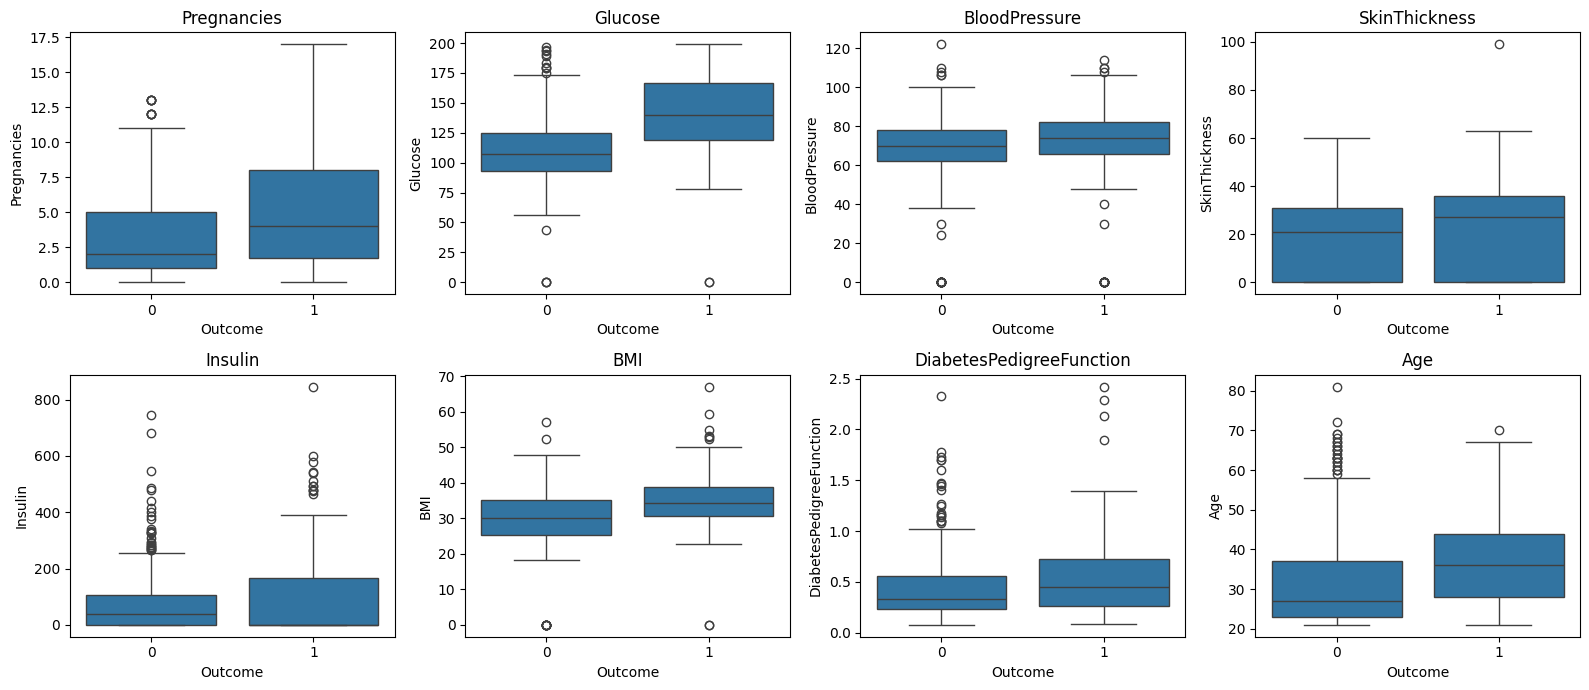

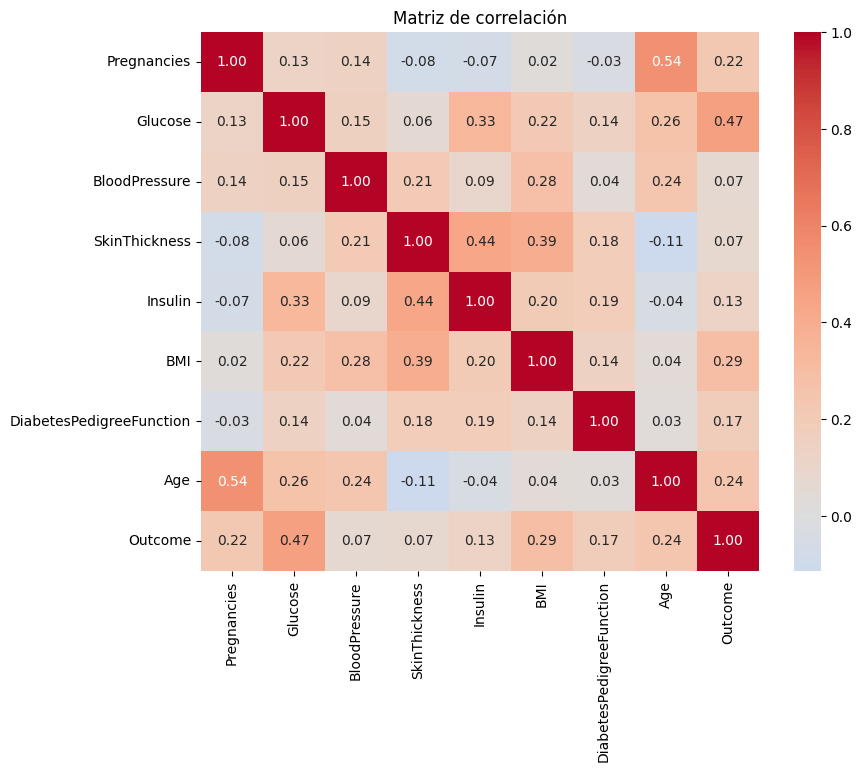

In [9]:
# =========================
# Paso 2: EDA rápido
# =========================
df.info()
display(df.describe().T)

# Balance de la clase
cls_counts = df['Outcome'].value_counts().sort_index()
print("\nDistribución de Outcome (0 = no diabetes, 1 = diabetes):\n", cls_counts)
print("Proporción clase positiva:", cls_counts[1] / cls_counts.sum())

# Univariantes numéricos
_ = df.drop(columns=['Outcome']).hist(bins=20, figsize=(12,8)); plt.tight_layout(); plt.show()

# Bivariantes simples contra Outcome
fig, axes = plt.subplots(2, 4, figsize=(16,7))
axes = axes.ravel()
for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, x='Outcome', y=col, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout(); plt.show()

# Correlaciones
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación"); plt.show()


In [10]:
# =======================================================
# Limpieza: tratar 0 como 'missing' en variables clínicas
# =======================================================
# En este dataset, 0 suele ser "no medido" para estas columnas:
zero_as_na = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

df_clean = df.copy()
for c in zero_as_na:
    df_clean[c] = df_clean[c].replace(0, np.nan)

# Chequeo de nulos introducidos
df_clean.isna().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [11]:
# Imputación simple (mediana) para valores faltantes
from sklearn.impute import SimpleImputer

X = df_clean.drop(columns=['Outcome'])
y = df_clean['Outcome']

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split estratificado (¡muy importante en clasificación!)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((614, 8),
 (154, 8),
 np.float64(0.3485342019543974),
 np.float64(0.35064935064935066))

In [ ]:
# =======================================================
# Paso 3: XGBoost (clasificación) — modelo base + prueba rápida
# =======================================================

# Si no tienes xgboost instalado en tu entorno, descomenta la línea:
# !pip install xgboost

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Función de evaluación (la dejamos porque ya la venías usando en el proyecto anterior)
def eval_model(model, X_tr, y_tr, X_te, y_te, name=""):
    # Entrenamos el modelo
    model.fit(X_tr, y_tr)

    # Predicción de clases
    y_pred = model.predict(X_te)

    # Probabilidad de la clase positiva (1 = diabetes) para ROC-AUC
    proba = model.predict_proba(X_te)[:, 1]

    # Métricas principales
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    auc  = roc_auc_score(y_te, proba)

    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")

    # Matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
    plt.title(f"Matriz de confusión — {name}")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    }

# -------------------------
# Modelo base (muy cercano al default, pero fijamos lo esencial)
# -------------------------
xgb_base = XGBClassifier(
    objective="binary:logistic",  # clasificación binaria
    eval_metric="logloss",        # evita warnings y fija métrica interna
    random_state=42,
    n_estimators=200,             # número de árboles (rondas)
    learning_rate=0.05,           # tasa de aprendizaje
    max_depth=4,                  # complejidad del árbol
    subsample=0.8,                # filas por árbol
    colsample_bytree=0.8,         # columnas por árbol
    n_jobs=-1
)

base_results = eval_model(xgb_base, X_train, y_train, X_test, y_test, name="XGBoost — BASE")

# -------------------------
# Prueba rápida: variar 2 hiperparámetros y ver impacto en ROC-AUC
# (Esto NO es GridSearch aún; solo exploración rápida como hicimos con RF)
# -------------------------
results = []

depth_list = [2, 3, 4, 5, 7]
n_estimators_list = [100, 200, 400]
learning_rate = 0.05  # la dejamos fija para esta prueba

for d in depth_list:
    for n in n_estimators_list:
        model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_estimators=n,
            learning_rate=learning_rate,
            max_depth=d,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1
        )
        res = eval_model(model, X_train, y_train, X_test, y_test, name=f"XGB (depth={d}, n={n})")
        results.append(res)

# Elegimos el mejor por ROC-AUC (más estable que accuracy en datasets algo desbalanceados)
best = max(results, key=lambda x: x["roc_auc"]) if results else base_results
print("\nMejor configuración (según ROC-AUC):", best)


,name,acc,prec,rec,f1,auc
0,DecisionTree (gini),0.681818,0.553191,0.481481,0.514851,0.635741
1,DecisionTree (entropy),0.675325,0.538462,0.518519,0.528302,0.639259
2,DecisionTree (log_loss),0.675325,0.538462,0.518519,0.528302,0.639259


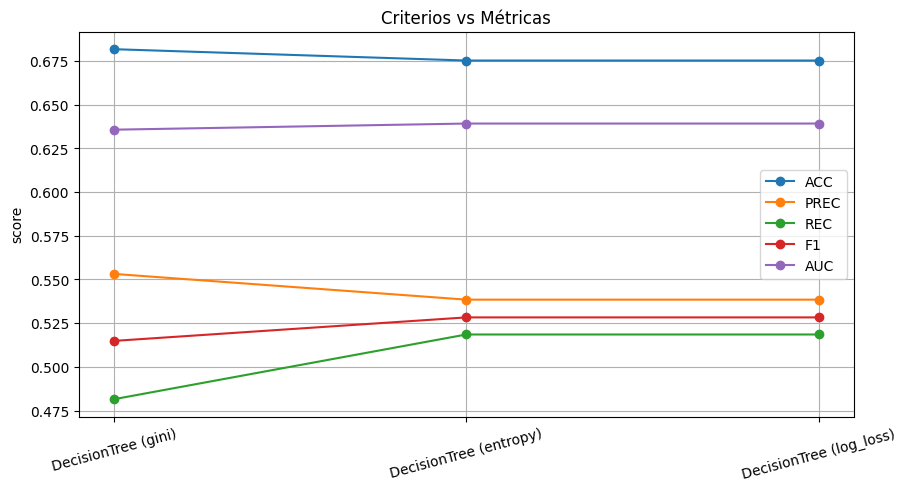

In [13]:
# Comparación gráfica de métricas por criterio
if results:
    df_res = pd.DataFrame([{k:v for k,v in r.items() if k!='model'} for r in results])
    display(df_res[['name','acc','prec','rec','f1','auc']])

    plt.figure(figsize=(10,5))
    for metric in ['acc','prec','rec','f1','auc']:
        plt.plot(df_res['name'], df_res[metric], marker='o', label=metric.upper())
    plt.xticks(rotation=15); plt.ylabel("score"); plt.title("Criterios vs Métricas"); plt.legend(); plt.grid(True); plt.show()


Mejor por AUC/F1: DecisionTree (entropy)


,importance
Glucose,0.277088
DiabetesPedigreeFunction,0.140549
BMI,0.137650
BloodPressure,0.131495
Pregnancies,0.096240
Age,0.089012
Insulin,0.079433
SkinThickness,0.048532


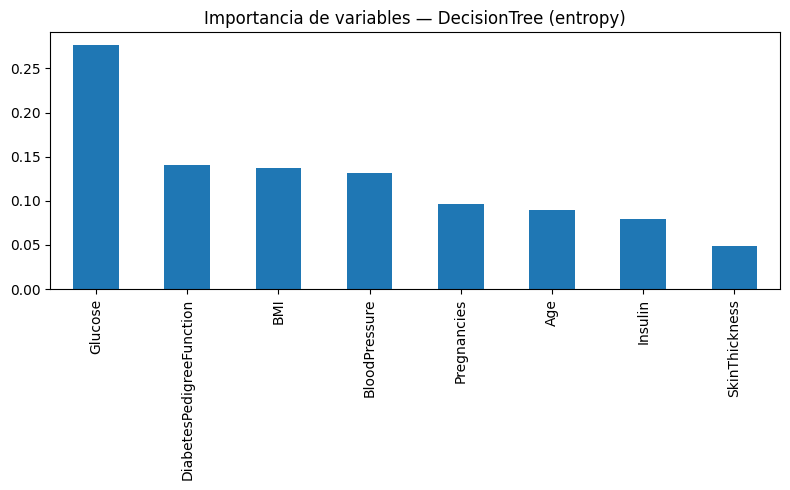

In [14]:
# Importancias de características del mejor resultado (por F1 o AUC)
if results:
    # priorizamos AUC; si es NaN, usamos F1
    best = max(results, key=lambda r: (np.nan_to_num(r['auc'], nan=-1), r['f1']))
    best_model = best['model']
    print("Mejor por AUC/F1:", best['name'])

    importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    display(importances.to_frame("importance").head(15))

    plt.figure(figsize=(8,5))
    importances.head(15).plot(kind='bar')
    plt.title(f"Importancia de variables — {best['name']}")
    plt.tight_layout(); plt.show()


In [ ]:
# =======================================================
# Paso 4: Optimización con GridSearch (XGBoost)
# =======================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

# Basamos el punto de partida en lo que salió mejor en la prueba rápida (si existe)
# Si por alguna razón 'best' no existe, usamos valores seguros por defecto.
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

xgb = XGBClassifier(**base_params)

# Grid de hiperparámetros (moderado para no tardar demasiado)
param_grid = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.5, 1.0]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",   # buena métrica para clasificación binaria
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score CV (ROC-AUC):", grid.best_score_)

best_xgb = grid.best_estimator_

# Evaluación final del mejor modelo en test
final = eval_model(best_xgb, X_train, y_train, X_test, y_test, name="XGBoost — GridSearch (mejor)")


In [ ]:
# =========================
# Paso 5: Guardar el modelo
# =========================

# Guardamos el modelo como JSON (formato recomendado por XGBoost)
best_xgb.save_model("xgb_classifier_diabetes_best_42.json")
print("Modelo guardado como: xgb_classifier_diabetes_best_42.json")
